In [1]:
## Using a custom weight matrix with CUBA example from Brian2 docs

location = '/home/pshah/Documents/code/'
import sys; sys.path.append('%sutils_praj' % location)
sys.path.append('%sNeuronalModelling/' % location)

import random
import numpy as np
import matplotlib.pyplot as plt


# recurrent layer
Nn = 4000  # number of neurons in the recurrent layer
W = np.zeros([Nn, Nn])  # matrix of recurrent connection weights, should be a Nn x Nn size array
# W = np.diag(np.ones(Nn)) # -- self connections

def resetw(W=W):
    W = np.zeros([W.shape[0], W.shape[1]])
    return W

# modifying recurrent connection weights as you want to for the network



In [2]:
# %% building a spatially localized connectivity matrix
####################################################

W = resetw()

p_e = 0.2  # probability of e-e connections
p_i = 0.2  # probability of Inh. neurons

Ne = random.sample(range(Nn), int(0.8*Nn))
Ni = [x for x in range(Nn) if x not in Ne]
struc_num = 200

# need to intersperse E and I neurons throughout the whole cell population
for i in range(Nn):
    # select random indexes to setup as connections based on selected probability
    # set E --> all connectivity
    if i in Ne:
        j = [int(target) for target in np.random.normal(i,struc_num, int(p_e*len(W[i]))) if 0 < target < Nn]
        W[i, j] = 1

    # set I --> all connectivity
    elif i in Ni:
        j = [int(target) for target in np.random.normal(i, struc_num, int(p_i * len(W[i]))) if 0 < target < Nn]
        W[i, j] = 1

i, j = W[Ni].nonzero()
sources = [Ni[x] for x in i]
targets = [range(Nn)[x] for x in j]

In [3]:
# Brian2 network

from brian2 import *
from brian2_recurrentnet_seizures.brian2_utils import *

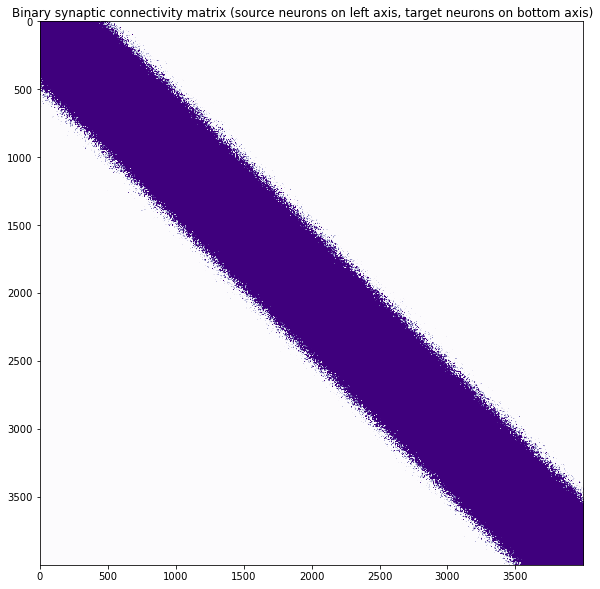

In [4]:
# %% plot connectivity matrix
plot_connectivity_matrix(conn_matrix=W)

Starting simulation at t=0. s for a duration of 3. s
3. s (100%) simulated in 2s


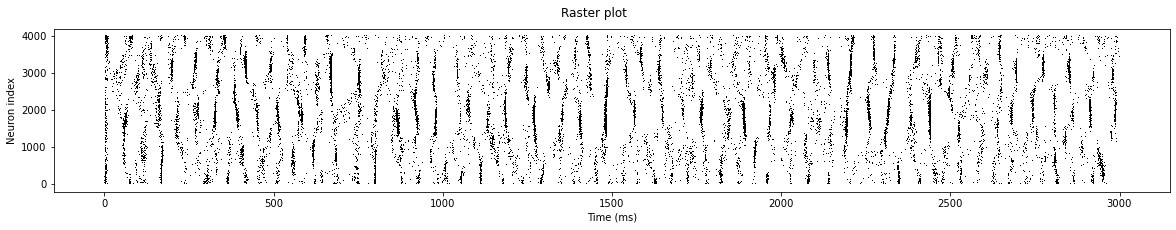

In [5]:
#%% original CUBA model from Brian2
start_scope()

runtime = 3 * second
dt = 0.1*ms

taum = 20*ms
taue = 5*ms
taui = 10*ms
Vt = -50*mV
Vr = -60*mV
El = -49*mV

eqs = """
dv/dt  = (ge+gi-(v-El))/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
"""

P = NeuronGroup(4000, eqs, threshold='v>Vt', reset='v = Vr', refractory=5*ms,
                method='exact')

# initialization
P.v = "Vr + rand() * (Vt - Vr)"
# P.v = 'Vr'
P.ge = 0*mV
P.gi = 0*mV

# make synaptic connections and specify the synaptic model
w_e = (60*0.27/10)*mV # excitatory synaptic weight (voltage)  (this is equal to [E_exc = 0mV - V_rest = -60mV] * g_exc = 0.27nS
w_i = (-20*4.5/10)*mV # inhibitory synaptic weight


# using custom synaptic connectivity matrix from above
Ce = Synapses(P, P, on_pre='ge += w_e')
i, j = W[Ne].nonzero()
sources = [Ne[x] for x in i]
targets = [range(Nn)[x] for x in j]
Ce.connect(i=sources, j=targets)

Ci = Synapses(P, P, on_pre='gi += w_i')
i, j = W[Ni].nonzero()
sources = [Ni[x] for x in i]
targets = [range(Nn)[x] for x in j]
Ci.connect(i=sources, j=targets)


trace = StateMonitor(P, 'v', record=[1, 10, 400, 600])
s_mon = SpikeMonitor(P)

run(runtime, report='text')

plot_raster(spike_monitor = s_mon)

collected binned spikes rasters...


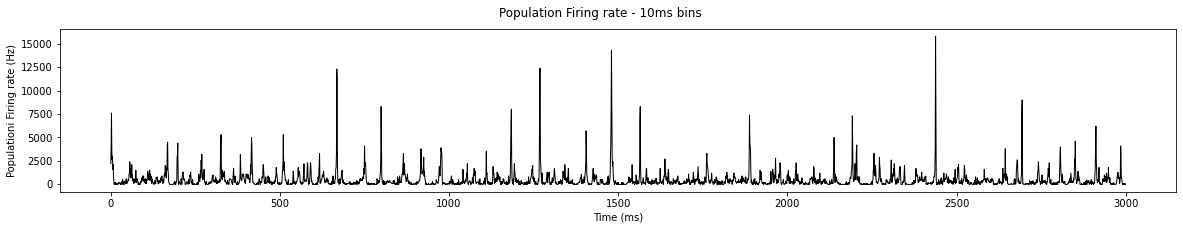

collected binned spikes rasters...


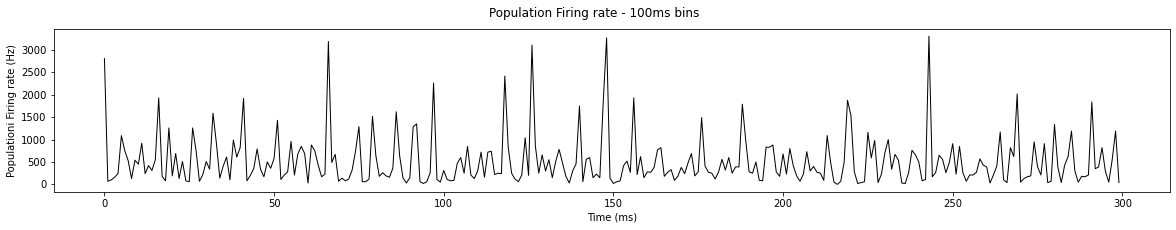

In [6]:
spike_monitor_trains = [(array/dt).astype(int64) for array in list(s_mon.spike_trains().values())]

spike_monitor_trains_e = [spike_monitor_trains[i] for i in range(len(spike_monitor_trains)) if i in Ne]

# create numpy array of spikes:
spike_array, spike_counts_binned, spike_raster_binned = make_spike_array(spike_monitor_trains=spike_monitor_trains_e, ntotal=len(Ne), runtime=runtime, dt=dt, binsize=10)
plot_firing_rate(spike_raster_binned, binsize_sec=0.01, title='Population Firing rate - 10ms bins')

spike_array_100, spike_counts_binned_100, spike_raster_binned_100 = make_spike_array(spike_monitor_trains=spike_monitor_trains_e, ntotal=len(Ne), runtime=runtime, dt=dt, binsize=100)
plot_firing_rate(spike_raster_binned_100, binsize_sec=0.1, title='Population Firing rate - 100ms bins')

# spike_array, spike_counts_binned, spike_raster_binned = make_spike_array(spike_monitor_trains=spike_monitor_trains_e, ntotal=len(Ne), runtime=runtime, dt=dt, binsize=50)
# plot_firing_rate(spike_raster_binned, binsize_sec=0.1, title='Population Firing rate - 50ms bins')



## code for Mean Phase Coherence quantification metric

In [7]:
# DUMMY DATA
# spike_array = np.array([[0,1,0,1,0,1], [0,1,0,1,0,1], [0,0,0,1,0,1]])

In [8]:

# mpc_list2 = []
# for i in range(spike_array.shape[0]):
#     spks = np.where(spike_array[i] == 1)[0]
#     if len(spks) > 0:
#         for j in range(spike_array.shape[0]):
#             message = 'considering neuron i = %s, and j = %s; mean phase coherence values collected: %s' % (i, j, len(mpc_list2))
#             print(message, end='\r')
#             if i != j:
#                 sigma_i = 0
#                 spks_2 = np.where(spike_array[j] == 1)[0]
#                 if len(spks_2) > 0:
#                     for t2_k in spks:
#                         # print(t2_k)
#                         if len(spks_2[np.where(spks_2 < t2_k)]) > 0 and len(spks_2[np.where(spks_2 >= t2_k)]) > 0:
#                             t1_k = np.max(spks_2[np.where(spks_2 < t2_k)])
#                             t1_k1 = np.min(spks_2[np.where(spks_2 >= t2_k)])
#                             phi_k = 2*np.pi*((t2_k - t1_k)/(t1_k1 - t1_k))
#                             sigma_i += np.exp(1j*phi_k)
#                     result = np.abs(1/len(spks) * sigma_i)
#                     mpc_list2.append(result)
                        
# np.mean(mpc_list2)
    

## PCA fit exponent

In [9]:
def powerlawfit(data: np.array, fit_subset: list = None, plot_subset: list = None):
    x = range(len(data))[fit_subset[0]:fit_subset[1]]
    y = data[fit_subset[0]:fit_subset[1]]


    # to perform powerlaw fit, first take data into log-log space and then do linear regression in that space
    res = stats.linregress(np.log10(x), np.log10(y))
    print(res)

    x_fit = range(len(data))[fit_subset[0]:fit_subset[1]]
    y_fit = res.intercept + res.slope * np.log10(x_fit)

    fig, ax = plt.subplots(figsize=[6,6])
    ax.plot(np.log10(range(len(data))[plot_subset[0]:plot_subset[1]]), np.log10(data[plot_subset[0]:plot_subset[1]]), label='original data', color='darkblue')
    ax.plot(np.log10(x_fit), y_fit, c = 'darkgreen', label='fitted line')
    ax.legend()
    ax.set_xlabel('PC Dimension (log10)')
    ax.set_ylabel('Variance (|eigenvalue|)')
    plt.show()

    return res.slope

n dims: 300
LinregressResult(slope=-0.5586287176623238, intercept=-1.3390213868942429, rvalue=-0.992102364474406, pvalue=3.90315553630256e-81, stderr=0.0075288701375873165, intercept_stderr=0.012732781721755416)


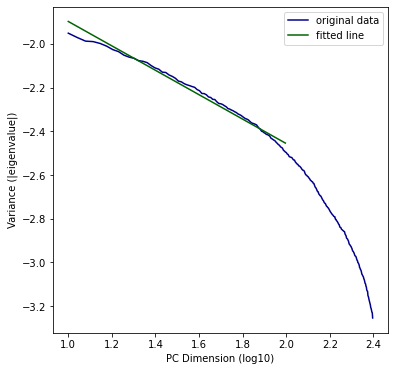

In [10]:
explained_variance_ratio_ = pca_spike_raster(spike_raster_binned_100)
print("n dims:", len(explained_variance_ratio_))
alpha = powerlawfit(data = explained_variance_ratio_, fit_subset = [10,100], plot_subset = [10, 250])

## pearson's correlation

WARNING    /home/pshah/anaconda3/envs/2021/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /home/pshah/anaconda3/envs/2021/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 [py.warnings]


0.005280781421825211


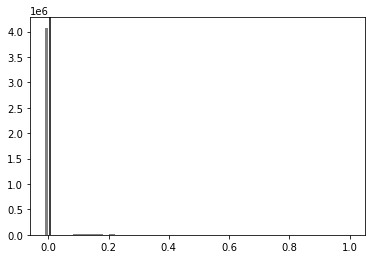

In [11]:
#%% calculate correlation coefficients
corr_mtx = np.corrcoef(spike_raster_binned)
x = corr_mtx[np.triu_indices(corr_mtx.shape[0], k=1)]
# not sure why but there are nan values coming up in the corr_values calculation
# remove nans from corr_values

corr_values = x[~np.isnan(x)]
avg_corr = np.mean(corr_values)
print(np.mean(corr_values))

plt.hist(corr_values, bins=100, color='gray')
plt.axvline(x=avg_corr, color='black')
plt.show()